# Executive Summary

This notebook will attempt to answer the following research question:

    What's money got to do with it?

## PLANNING

- [X] Planning
    - [X] import libraries/packages
    - [X] configure notebook environment
    - [X] define helper functions
- [X] Acquire data
    - [X] get PEIMS financial data
    - [X] get STAAR performance data
- [X] Prepare the data
    - [X] prepare PEIMS data
        - [X] get rid of unwanted columns
        - [x] get rid of NaNs
    - [X] prepare STAAR data
        - [X] get rid of duplicates
        - [X] get rid of unwanted columns
        - [X] get rid of NaNs
        - [X] create new columns
        - [X] merge two datasets together
- [ ] Explore the data
    - [ ] examine for multicollinearity and determine truly independent variables
    - [ ] get to know the master dataset
    - [ ] feature engineering
- [ ] Modeling
    - [ ] create, fit, use XGBoost
    - [ ] gridsearch
    - [ ] retrain model using best hyperparameters
    - [ ] extract feature importances

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# For hypothesis testing
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# For data preparation
from sklearn.model_selection import train_test_split

# For modeling
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from xgboost import plot_importance

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

ALPHA = 0.05
mannwhitneyu_same = []
mannwhitneyu_diff = []

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('=====================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

In [3]:
def viz_correlation(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    
    # Use the default Pearson for continuous variables
    corr_matrix = dfx.corr(method ='pearson')

    # Setup
    fig, ax = plt.subplots(figsize=(16,8))

    # vmin and vmax control the range of the colormap
    sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt='.2f',
               vmin=-1, vmax=1)

    plt.title(graph_title)

    # Add tight_layout to ensure the labels don't get cut off
    plt.tight_layout()
    plt.show()

In [4]:
def viz_scatter(df, graph_title, col1, col2):
    plt.figure(figsize=(16, 8))
    plt.scatter(df[col1], df[col2], alpha=0.5)
    plt.xlabel(col1) #x label
    plt.ylabel(col2) #y label
    plt.title(graph_title)
    plt.show()

In [5]:
def viz_pairplot(df, graph_title, *cols):
     
    dfx = df[list(cols)]
    plt.figure(figsize=(16, 8))
    sns.pairplot(dfx)
    plt.title(graph_title)
    plt.show()

In [6]:
def loop_levene(df1, df2):
    for column in df1.columns:
        result = stats.levene(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - HOMOGENOUS'
        else:
            interpretation = 'significant - HETEROGENOUS'
        print(result, '-', column, ' - ', interpretation)

In [7]:
def loop_shapiro(df):
    for column in df.columns:
        statistic, result = shapiro(df[column])
        if result > ALPHA:
            interpretation = 'insignificant - NORMAL'
        else:
            interpretation = 'significant - ABNORMAL'
        print(result, '-', column, ' - ', interpretation)

In [8]:
def loop_ttest(df1, df2):
    for column in df1.columns:
        result = stats.ttest_ind(df1[column], df2[column])[1]
        if result > ALPHA:
            interpretation = 'insignificant - SAME'
        else:
            interpretation = 'significant - DIFFERENT'
        print(result, '-', column, ' - ', interpretation)

In [9]:
def loop_mannwhitney(df1, df2):

    for column in df1.columns:
        stat, p = mannwhitneyu(df1[column], df2[column])

        if p > ALPHA:
            interpretation = 'SAME (fail to reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_same.append(column)
        else:
            interpretation = 'DIFFERENT (reject H0)'
            print('Statistics=%.3f, p=%.3f' % (stat, p) + ' - ' + column + ' - ' + interpretation)
            mannwhitneyu_diff.append(column)

In [10]:
def viz_boxplot(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.boxplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [11]:
def viz_violin(df, col1, col2, graph_title):
    plt.figure(figsize=(16, 8))
    sns.violinplot(x = col1, y = col2, data = df)
    plt.title(graph_title)
    plt.show()

In [12]:
def my_plot_importance(booster, figsize, **kwargs): 
    fig, ax = plt.subplots(1,1,figsize=figsize)
    
    return plot_importance(booster=booster, ax=ax, **kwargs)

## ACQUIRE DATA

In [13]:
# Get the PEIMS and STAAR datasets
ethnic = pd.read_csv('../data/inter/clean_ethnic_2019.csv')
staar = pd.read_csv('../data/inter/clean_staar_2019.csv')
peims = pd.read_csv('../data/inter/clean_peims_2019.csv')

In [14]:
ethnic.head()
staar.head()
peims.head()

,District,Percentage of Non-White Students
0,1902,0.145315
1,1903,0.211415
2,1904,0.213158
3,1906,0.268657
4,1907,0.717973


,District,Total Number of Students,Total Number of Passing Students
0,1902,932,842
1,1903,1991,1651
2,1904,1365,1064
3,1906,569,420
4,1907,5497,3274


,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Total Program Expenditures,Other Uses
0,1902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,304174,1858660,8558886,48633
1,1903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,339045,3262276,11696322,102465
2,1904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,571388,2445660,8802724,481
3,1906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,1412589,4021890,53786
4,1907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,1214433,10940857,36374344,0


## PREPARATION

In [15]:
ethnic = ethnic.astype({"District": str})
staar = staar.astype({"District": str})
peims = peims.astype({"District": str})

In [16]:
# Padd District numbers with 0's
ethnic['District'] = ethnic['District'].str.zfill(6)
staar['District'] = staar['District'].str.zfill(6)
peims['District'] = peims['District'].str.zfill(6)

In [17]:
ethnic.head()
ethnic.shape

staar.head()
staar.shape

peims.head()
peims.shape

,District,Percentage of Non-White Students
0,001902,0.145315
1,001903,0.211415
2,001904,0.213158
3,001906,0.268657
4,001907,0.717973


(1201, 2)

,District,Total Number of Students,Total Number of Passing Students
0,001902,932,842
1,001903,1991,1651
2,001904,1365,1064
3,001906,569,420
4,001907,5497,3274


(1251, 3)

,District,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Total Program Expenditures,Other Uses
0,001902,6025217,1075904,648206,809559,4649118,66490,4986,270353,306385,998314,0,37882,293070,287406,413755,284553,773085,0,173489,0,2778638,3968,251350,3005575,273747,9599,40285,32890,304174,1858660,8558886,48633
1,001903,9093950,1514689,784631,303052,7043892,117860,33175,66374,574699,202086,0,33657,422887,630202,598484,558948,1248908,13530,151120,500,5313722,93,852319,1028587,799037,0,101243,0,339045,3262276,11696322,102465
2,001904,6659596,927209,937810,278109,4611747,51126,157830,0,466345,199338,0,102385,38800,411195,754465,539512,1014501,45482,409998,0,3945494,10154,552217,726827,377013,0,59567,114404,571388,2445660,8802724,481
3,001906,3134475,373513,408024,105878,2087166,19990,0,7905,379101,75235,0,40628,148301,257465,210240,201520,465549,10415,118375,0,1499301,14498,164641,447072,402415,2706,48748,29920,0,1412589,4021890,53786
4,001907,25587063,5603896,4134969,1048416,18807861,167823,535649,1033275,2201907,1443630,170074,208736,1442619,2071781,1422648,1287489,3937087,242658,1006175,394932,15527277,39671,1625090,2422707,3147717,231026,302531,923035,1214433,10940857,36374344,0


(1200, 33)

In [18]:
df = pd.merge(peims, staar, on=['District'])
df = pd.merge(df, ethnic, on=['District'])
df = df.drop(columns=['District'])

In [19]:
df['Efficiency'] = (df['Total Program Expenditures'] / (df['Total Number of Passing Students'] / df['Total Number of Students']))/df['Percentage of Non-White Students']

In [20]:
df = df.drop(columns=['Total Program Expenditures',
                      'Total Number of Passing Students',
                      'Total Number of Students',
                      'Percentage of Non-White Students'
                     ])

In [21]:
df['Efficiency'].describe()

count    1.250000e+03
mean              inf
std               NaN
min      1.279219e+06
25%      1.698822e+07
50%      4.214819e+07
75%      1.107709e+08
max               inf
Name: Efficiency, dtype: float64

In [22]:
df['Efficiency'].quantile(q=.25)

16988223.566631433

In [23]:
df_pass = df[df['Efficiency'] <=  df['Efficiency'].quantile(q=.25)]
df_fail = df[df['Efficiency'] >   df['Efficiency'].quantile(q=.25)]

In [24]:
df_pass.shape
df_fail.shape

(313, 32)

(937, 32)

In [25]:
df_pass['Performance'] = 1
df_fail['Performance'] = 0

C:\Users\Dd\AppData\Local\Temp\ipykernel_33456\4042116679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pass['Performance'] = 1
C:\Users\Dd\AppData\Local\Temp\ipykernel_33456\4042116679.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['Performance'] = 0


In [26]:
df_pass = df_pass.drop(columns=['Efficiency'])
df_fail = df_fail.drop(columns=['Efficiency'])

In [27]:
df_pass.head()

,Payroll,Professional & Contracted,Supplies & Materials,Other Operating,Instruction & Transfer,Instructional Resource Media,Curriculum/Staff Development,Instructional Leadership,Campus Administration,Guidance & Counseling,Social Work,Health Services,Transportation,Food Service,Extracurricular,General Administration,Plant Maintenance/Operation,Security & Monitoring,Data Processing,Community Services,Regular Program,Gifted & Talented Program,Career & Technology Program,Students with Disabilities,State Compensatory Education,Bilingual Program,High School Allotment,Pre-K,Athletics Program,Undistributed Program,Other Uses,Performance
19,3481271,405820,437489,174214,2554924,41212,7951,0,251616,53537,0,59433,129778,204352,353938,318749,511827,7977,3500,0,1961002,10052,295410,274796,349642,49596,52162,0,308249,1197885,27531,1
21,4728729,766725,789181,166853,3410008,62089,48861,19724,391750,152892,16888,62153,159498,437113,230575,503345,753567,29953,173072,0,2417784,10435,208744,533595,872522,53031,37766,67204,174891,2075516,83022,1
37,3131432,402613,327969,98962,1997529,54863,154044,78113,221469,60118,0,765,110814,238107,146989,372736,371298,7866,142842,3423,1669697,13406,128705,320434,280379,8554,2811,126112,97262,1313616,44597,1
39,3552237,495063,529092,246376,2515831,39974,71314,141152,214970,165189,0,16166,0,303325,99061,523868,599933,14827,99438,17720,2276410,17261,0,273023,583525,6596,0,0,0,1665953,0,1
41,3381878,555065,237324,115179,2898047,1320,33399,0,195849,75064,0,68524,153812,116299,55849,242291,321631,4664,122553,144,880600,2229,0,180296,460025,1884,0,1748087,50552,965773,58110,1


In [28]:
df = pd.concat([df_pass, df_fail])

In [29]:
X = df.drop("Performance", axis=1)
y = df['Performance']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=493, stratify=y)

## MODELING

In [43]:
# Init classifier
xgb_cl = xgb.XGBClassifier(random_state=493)

# Fit
xgb_cl.fit(X_train, y_train)

# Predict
preds = xgb_cl.predict(X_test)

# Score
print('Accuracy Score: ' + str(accuracy_score(y_test, preds)))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=493,
              reg_alpha=0, reg_lambda=1, ...)

Accuracy Score: 0.9093333333333333


In [32]:
# make predictions for test data
y_pred = xgb_cl.predict(X_test)
predictions = [round(value) for value in y_pred]

In [44]:
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy Score: %.2f%%" % (accuracy * 100.0))

Accuracy Score: 90.93%


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

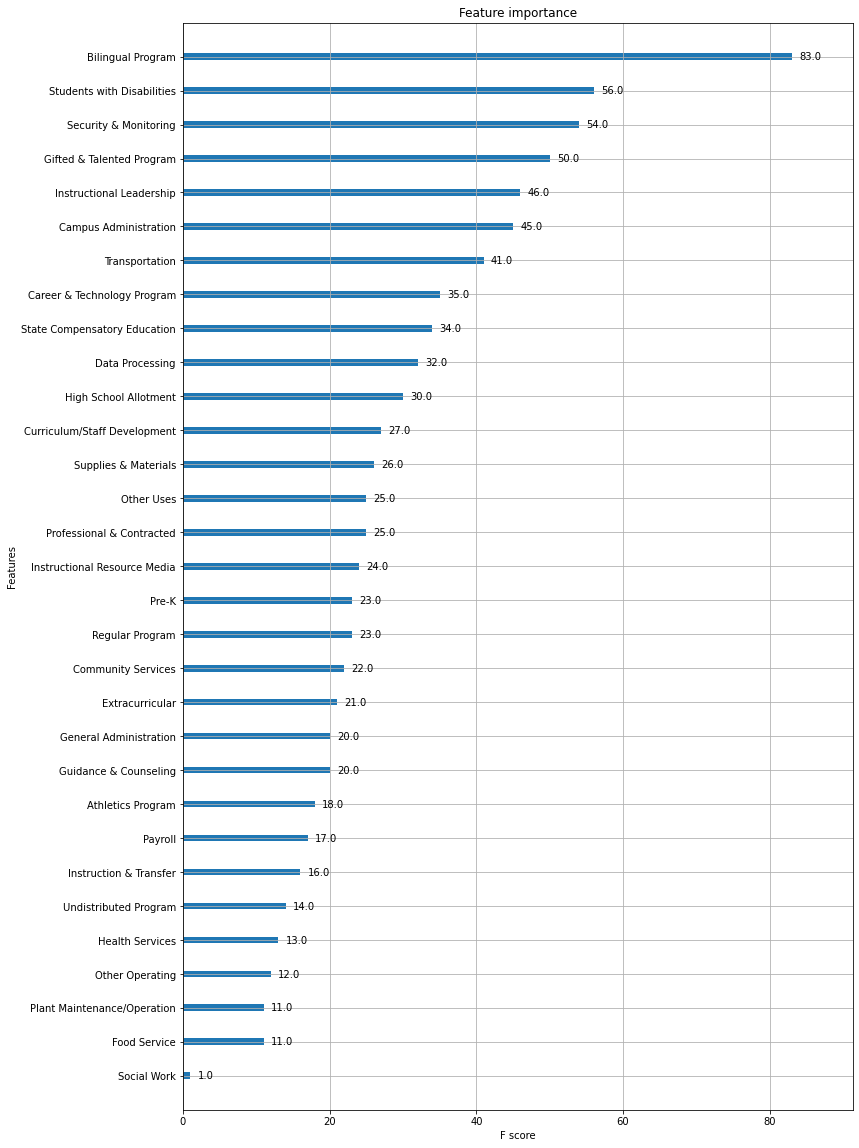

In [34]:
my_plot_importance(xgb_cl, (12, 20))

Text(0.5, 1.0, 'Receiver Operating Characteristic')

(0.0, 1.0)

(0.0, 1.0)

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 0, 'False Positive Rate')

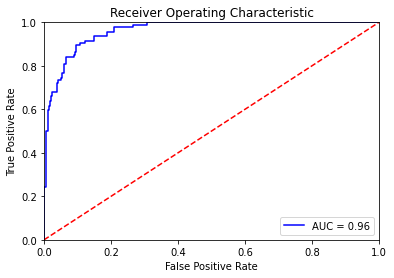

In [87]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = xgb_cl.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [84]:
test_budget = pd.DataFrame(X.iloc[1000]).T

# look at secondrow as an array
test_budget.values

# predict
test_result = xgb_cl.predict(test_budget)

test_result # [0] means the district would do poorly

array([[20877816,  3627405,  2991776,  1086384, 14259454,   279270,
          807437,   764731,  1521095,   799091,   278126,   206116,
         1176363,  1496366,   848458,  1398110,  4162912,   179332,
          389751,    16769,  9272917,    66866,  1127046,  3140199,
         5175144,   151176,   205552,     8978,   567913,  8867590,
          807452]], dtype=int64)

array([0])

In [86]:
test_budget = pd.DataFrame(X.iloc[111]).T

# look at secondrow as an array
test_budget.values

# predict
test_result = xgb_cl.predict(test_budget)

test_result # [0] means the district would perform well

array([[618601, 208545,  89382,  32558, 490236,   8987,   1747,      0,
          5699,      0,      0,   2410,  75223,  68302,   1697, 175000,
        100711,      0,  19074,      0, 460099,    608,      0,  14394,
         33978,      0,      0,      0,      0, 440007,  68189]],
      dtype=int64)

array([1])